In [40]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np


df = pd.read_csv("/Users/samuelescarfone/Desktop/Predicting-Credit-Card-Defaults/data/cdp.csv", header=1)
df.head(5)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Cleaning & Preparing the Data

#### Convert Text Values into Integers

In [41]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in df:
    if df[col].dtype =='object':
        df[col] = encoder.fit_transform(df[col])

In [42]:
target = 'default payment next month'
print(df.isnull().sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


#### Remove Non-Categorical Data and Columns Highly Uncorrelated With Target

Let's check the correlation matrix to see which features are most strongly related to the target. This helps us identify what's actually important.

Unique values per column:
ID                            30000
BILL_AMT1                     22723
BILL_AMT2                     22346
BILL_AMT3                     22026
BILL_AMT4                     21548
BILL_AMT5                     21010
BILL_AMT6                     20604
PAY_AMT1                       7943
PAY_AMT2                       7899
PAY_AMT3                       7518
PAY_AMT6                       6939
PAY_AMT4                       6937
PAY_AMT5                       6897
LIMIT_BAL                        81
AGE                              56
PAY_4                            11
PAY_3                            11
PAY_2                            11
PAY_0                            11
PAY_6                            10
PAY_5                            10
EDUCATION                         7
MARRIAGE                          4
SEX                               2
default payment next month        2
dtype: int64


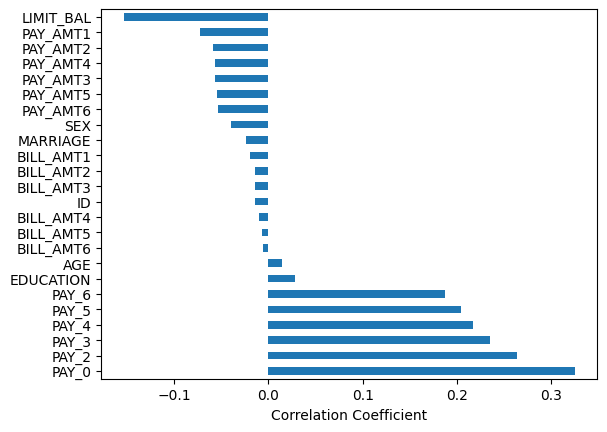

In [43]:
corr = df.corr(numeric_only=True)
corr.head(10)
corr_with_default = corr[target].sort_values(ascending=False)

uniqueRows = df.nunique().sort_values(ascending=False)
print("Unique values per column:")
print(uniqueRows)

#Barplot
corr_with_default.drop(target).plot(kind='barh')
plt.xlabel('Correlation Coefficient')
plt.show() 



I'm dropping `LoanID` because it's just a unique identifier and doesn't help with prediction. I'll keep the other numerical columns since they contain useful continuous data.

In [44]:

df = df.drop(columns=['ID'])
df.dropna(inplace=True)

In [45]:
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [46]:
df[target].value_counts()

default payment next month
0    23364
1     6636
Name: count, dtype: int64

In [47]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


# Native Bayes Model

- Randomize Data and Split into Train and Test Sets

In [48]:
np.random.seed(1234)
randomize_data = df.sample(frac=1) 
train_size = int(0.8 * len(randomize_data))
training = randomize_data[:train_size].reset_index(drop=True)
testing = randomize_data[train_size:].reset_index(drop=True)
print("Training shape:", training.shape)
print("Testing size:", testing.shape)


Training shape: (24000, 24)
Testing size: (6000, 24)


In [49]:
training[target].value_counts(normalize=True)

default payment next month
0    0.777958
1    0.222042
Name: proportion, dtype: float64

In [50]:
testing[target].value_counts(normalize=True)

default payment next month
0    0.782167
1    0.217833
Name: proportion, dtype: float64

In [51]:
trainX = training.iloc[:, :-1]
trainX = training.drop(columns=[target])

trainY = training[target]
colnames = trainX.columns

trainX.head(5)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,400000,1,1,1,34,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
1,80000,1,2,2,34,0,0,0,0,0,...,47655,43182,44332,45440,2600,4300,2000,2000,2000,2000
2,200000,2,3,1,49,1,-2,-1,-1,-1,...,2317,7588,7606,14053,0,2317,7588,7614,14053,0
3,20000,2,2,1,41,-1,-1,-1,-1,-1,...,1140,0,7014,7696,1087,1140,0,7014,800,0
4,70000,2,1,1,36,2,0,0,0,0,...,86287,65287,35345,9360,5000,3000,2000,3000,5000,0


In [52]:
testX = testing.iloc[:, :-1]
testX = testing.drop(columns=[target])

testY = testing[target]


In [53]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
trainBrnli = le.fit_transform(trainY)

trainBrnli[:5]

array([0, 0, 0, 0, 0])

#### Run Model on Training Data

In [54]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
trainX = enc.fit_transform(trainX)  
trainX = pd.DataFrame(trainX, columns=colnames)

trainX.head() 

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,41.0,0.0,1.0,1.0,13.0,0.0,0.0,0.0,0.0,0.0,...,291.0,316.0,311.0,333.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,0.0,2.0,2.0,13.0,2.0,2.0,2.0,2.0,2.0,...,10838.0,10538.0,10652.0,10675.0,2045.0,3080.0,1717.0,1729.0,1701.0,1684.0
2,20.0,1.0,3.0,1.0,28.0,3.0,0.0,1.0,1.0,1.0,...,1625.0,3394.0,3389.0,5163.0,0.0,1824.0,4308.0,4093.0,4931.0,0.0
3,2.0,1.0,2.0,1.0,20.0,1.0,1.0,1.0,1.0,1.0,...,1013.0,316.0,3218.0,3509.0,707.0,753.0,0.0,3970.0,725.0,0.0
4,7.0,1.0,1.0,1.0,15.0,4.0,2.0,2.0,2.0,2.0,...,13987.0,12697.0,9731.0,4027.0,3457.0,2301.0,1717.0,2367.0,3260.0,0.0


Since our features are continuous numbers (like Income, Loan Amount), `GaussianNB` is the right choice here. It assumes the data follows a normal distribution.

In [55]:
model = GaussianNB()  #create model object
model.fit(trainX,trainBrnli) 

,priors,None
,var_smoothing,1e-09


In [56]:
yhattrain = model.predict(trainX)

In [57]:
pd.crosstab(yhattrain, trainY)

default payment next month,0,1
row_0,,
0,16502,2763
1,2169,2566


In [58]:
print("Accuracy: ", str(accuracy_score(yhattrain, trainBrnli)*100) + "%")

Accuracy:  79.45%


### Model Performance on Test Data

In [59]:
print("testX shape:", testX.shape)
print("trainX shape:", trainX.shape)


testX shape: (6000, 23)
trainX shape: (24000, 23)


In [60]:
testBrnli = le.transform(testY)

testX = enc.fit_transform(testX) 

testX = pd.DataFrame(testX, columns=colnames) 
yhattest = model.predict(testX)
yhattest[:9] 


array([0, 0, 0, 0, 1, 0, 0, 1, 0])

In [61]:
acc = accuracy_score(yhattest, testBrnli)
print("Accuracy: "+str(acc*100)+"%")

Accuracy: 77.46666666666667%


Accuracy is useful, but I want to see the breakdown of errors. The confusion matrix will show us if we're missing actual defaults (False Negatives) or flagging good loans as bad (False Positives).

In [62]:
confM = confusion_matrix(testBrnli, yhattest)
print('Confusion matrix\n', confM)
print('True Negatives = ', confM[0,0])
print('False Positives = ', confM[0,1])
print('False Negatives = ', confM[1,0])
print('True Positives = ', confM[1,1])

Confusion matrix
 [[3924  769]
 [ 583  724]]
True Negatives =  3924
False Positives =  769
False Negatives =  583
True Positives =  724


In [63]:
pd.crosstab(yhattest, testY)
FNR  = confM[0,1] /(confM[1,1]+confM[0,1])
print(FNR)

0.5150703281982585


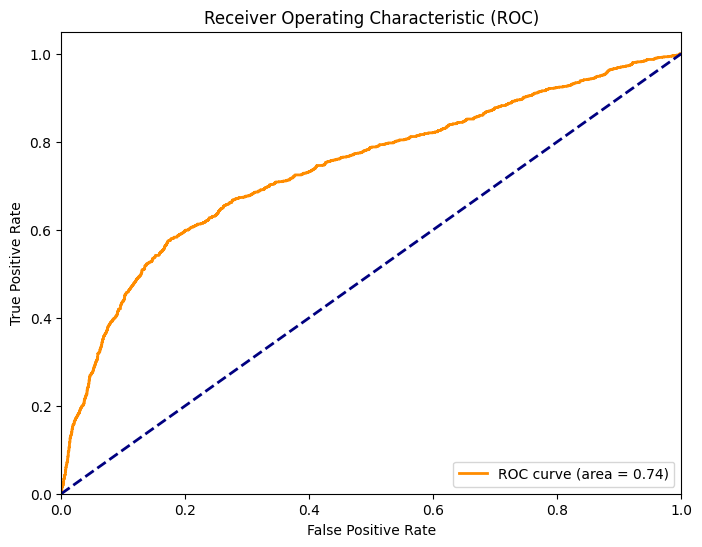

In [64]:
yProb = model.predict_proba(testX)[:,1]
fpr, tpr, thresholds = roc_curve(testBrnli, yProb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



In [65]:
from sklearn.metrics import classification_report
print(classification_report(testBrnli, yhattest))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4693
           1       0.48      0.55      0.52      1307

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000

